# Load NATL60 data on a dask cluster via xarray, time spectral analysis

Inspiration from Ryan's [notebook](https://github.com/rabernat/dask_distributed_demo/blob/master/notebooks/petascale_postprocessing_presentation.ipynb)


---

## Connect to dask cluster

In [1]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
from glob import glob

import xrft

#from dask.dot import dot_graph
from dask.array import from_array
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
from dask.diagnostics import visualize


In [2]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.expanduser('/home1/datawork/aponte/dask/scheduler.json'))
client
#print(client)
#print(client._repr_html_())

/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py:121: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


Client Scheduler: tcp://10.148.1.19:8786 Dashboard: http://10.148.1.19:8787,Cluster Workers: 48 Cores: 192 Memory: 480.00 GB


---

## Open dataset


In [3]:
dpath='/home/datawork-lops-osi/data/natl60/NATL60-CJM165/1d/3D/'
filenames = sorted(glob(dpath+'*_gridT.nc'))
print('Number of files available: %d' %len(filenames))

#for f in filenames:
#    print(f)

#filenames = filenames[:32]
print('Number of files processed: %d' %len(filenames))
#chunks={'time_counter': len(filenames), 'deptht': 1, 'x': 100, 'y': 100} # crash
chunks={'time_counter': 1, 'deptht': 1} # pass 9min  o1
#chunks={'time_counter': 1, 'deptht': 300, 'x': 100, 'y': 100} # pass 31min
#chunks={'time_counter': 1, 'deptht': 1, 'x': 100, 'y': 100} # crash
# distributed.core - WARNING - Event loop was unresponsive for 2.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
#=>> PBS: job killed: mem job total 104857600 kb exceeded limit 104857600 kb

%time ds = xr.open_mfdataset(filenames, concat_dim='time_counter', chunks=chunks, compat='equals') # slow, does not chunk along concat_dim
#%time ds = xr.open_mfdataset(filenames, concat_dim='time_counter', chunks=chunks, compat='equals', autoclose=True, lock=True)
#print(ds['votemper'])

Number of files available: 365
Number of files processed: 365
CPU times: user 1min 28s, sys: 1min 25s, total: 2min 54s
Wall time: 8min 14s


In [4]:
#ds = xr.open_mfdataset(filenames, concat_dim='time_counter', compat='equals')
#print(ds['votemper'])

In [5]:
# weird ... why can we not do that in open_mfdataset
chunks={'time_counter': len(filenames), 'deptht': 1, 'x': 100, 'y': 10}
%time ds=ds.chunk(chunks)
print(ds['votemper'])
# pass with o1

CPU times: user 4min 45s, sys: 7.95 s, total: 4min 53s
Wall time: 4min 52s
<xarray.DataArray 'votemper' (time_counter: 365, deptht: 300, y: 3454, x: 5422)>
dask.array<shape=(365, 300, 3454, 5422), dtype=float64, chunksize=(365, 1, 10, 100)>
Coordinates:
  * deptht         (deptht) float32 0.480455 1.55879 2.79421 4.18731 5.73867 ...
    nav_lat        (y, x) float32 dask.array<shape=(3454, 5422), chunksize=(10, 100)>
    nav_lon        (y, x) float32 dask.array<shape=(3454, 5422), chunksize=(10, 100)>
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(365,), chunksize=(365,)>
  * time_counter   (time_counter) datetime64[ns] 2012-10-01T12:00:00 ...
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 d
    cell_methods:        time: mean (interval: 40 s)


In [6]:
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
# detailed information about dataset content:
#ds.info()
# all arrays are dask arrays:
for name, da in ds.data_vars.items():
    print(name, da.data)

ds size in GB 32810.88

deptht_bounds dask.array<rechunk-merge, shape=(365, 300, 2), dtype=float32, chunksize=(365, 1, 2)>
time_counter_bounds dask.array<rechunk-merge, shape=(365, 2), dtype=float64, chunksize=(365, 2)>
vosaline dask.array<rechunk-merge, shape=(365, 300, 3454, 5422), dtype=float64, chunksize=(365, 1, 10, 100)>
votemper dask.array<rechunk-merge, shape=(365, 300, 3454, 5422), dtype=float64, chunksize=(365, 1, 10, 100)>


---

## Overview of the data

In [7]:
# this is slow given the simplicity of the task but may be the result of the poor adequation with the chunks
#ds['votemper'].isel(deptht=0,time_counter=0).plot(vmin=0., robust=True, figsize=(10, 6))
#plt.title('sea surface temperature snapshot')

---

## Compute spectrum along time at one location

In [8]:
# take the Fourier transform along one dimension
v_fft = xrft.dft(ds['votemper'].isel(deptht=0,x=2000,y=1000), dim=['time_counter'], shift=False, detrend='linear')
# multiply by complex conjugate
#pow_spec = (v_fft*v_fft.conj()).mean(dim=('x','y'))
E = (v_fft*v_fft.conj())
E = E.astype('f8').rename('t_power_spectrum (x,y)')

In [9]:
%time E.load();
#
E0=E

CPU times: user 6.3 s, sys: 452 ms, total: 6.75 s
Wall time: 48.7 s


(0.1, 100000.0)

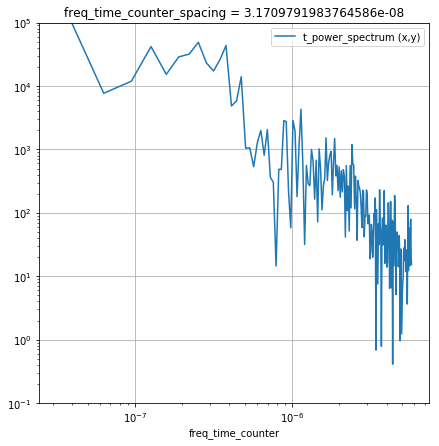

In [10]:
# and plot
fig, ax = plt.subplots(figsize=(7,7))
E0.plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); ax.set_ylim([1e-1,1e5])

---

## Compute spectrum along time at several locations

In [11]:
v_fft = xrft.dft(ds['votemper'].isel(deptht=0,y=1000).fillna(0.), dim=['time_counter'], shift=False, detrend='linear')
E = (v_fft*v_fft.conj()).where(v_fft!=0.,drop=True).mean(dim=('x')) # ,skipna=True
E = E.astype('f8').rename('t_power_spectrum (y)')

/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/xrft-0.1-py3.6.egg/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.


In [12]:
%time E.load();
#
E1=E

CPU times: user 6.11 s, sys: 452 ms, total: 6.56 s
Wall time: 3min 45s


(0.1, 100000.0)

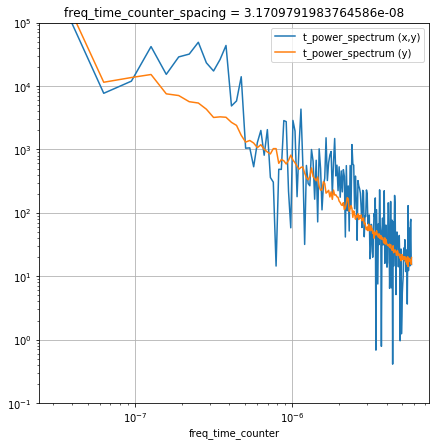

In [13]:
# and plot
fig, ax = plt.subplots(figsize=(7,7))
E0.plot(ax=ax)
E1.plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); ax.set_ylim([1e-1,1e5])

---

## Compute spectrum along time at many several locations

In [14]:
v_fft = xrft.dft(ds['votemper'].isel(deptht=0).fillna(0.), dim=['time_counter'], shift=False, detrend='linear')
E = (v_fft*v_fft.conj()).where(v_fft!=0.,drop=True).mean(dim=('x','y'))
E = E.astype('f8').rename('t_power_spectrum ()')

/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/xrft-0.1-py3.6.egg/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.


MemoryError: 

In [ ]:
%time E.load();
#
E2=E

In [ ]:
# and plot
fig, ax = plt.subplots(figsize=(7,7))
E0.plot(ax=ax)
E1.plot(ax=ax)
E2.plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); ax.set_ylim([1e-1,1e5])

---

## Visualizing the Dask Graph


In [ ]:
# make a much smaller version for visualization of the graph
#nt = 14
#dask_data = from_array(np.random.rand(nt, 400), chunks=(nt,10), name='raw_data')
#v = xr.DataArray(dask_data, dims=['time', 'x'],
#                 coords={'time': np.arange(nt), 'x': np.arange(400)})
#v_fft_= xrft.dft(v, dim=['time'], shift=False, detrend='linear')
#pow_spec = (v_fft_*v_fft_.conj()).mean(dim=('x'))

In [ ]:
#dot_graph(pow_spec_.data.dask)

In [ ]:
#fig, ax = plt.subplots(figsize=(7,7))
#pow_spec.plot(ax=ax)
#ax.legend(); ax.grid()
#ax.set_xscale('log'); ax.set_yscale('log')
#ax.set_ylabel(''); 
#ax.set_ylim([1e-1,1e1])